In [9]:
%reload_ext autoreload
%autoreload 2

import os
from glob import glob
import shutil
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom as zoom_interp
import nibabel as nib
import pandas as pd

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

def get_sim_lowdose(case_path):
    idx = -2
    
    fidx = lambda f: int(f.split('/')[-1].replace('.npy', '').replace('_', '').replace('t', ''))
    fpath_slices = sorted([f for f in glob('{}/*.npy'.format(case_path))], key=fidx)
    vol_data = []
    for fp in fpath_slices:
        sl_data = np.load(fp)
        vol_data.append(sl_data[idx])
    vol_data = np.array(vol_data)
    return vol_data
#     t1pre, t1low, t1post = vol_data
#     return (t1pre, t1low, t1post)

def resize512(vol):
    vol = zoom_interp(vol, (1, 2, 2))
    vol = np.clip(vol, 0, vol.max())
#     vol = vol / vol.mean()
#     vol = np.interp(vol, (vol.min(), vol.max()), (0, 1))
    return vol

<Figure size 720x576 with 0 Axes>

In [18]:
df_metrics = pd.read_csv('/home/srivathsa/projects/studies/gad/dose_sim_seg/dice.csv')
df_filt = df_metrics.query('Dice_Sgad > 0 and Dice_Sgad_sim > 0')
enh_cases =  ["Patient_0003", "Patient_0010", "Patient_0019", "Patient_0020", 
              "Patient_0025", "Patient_0034", "Patient_0040", "Patient_0052", 
              "Patient_0057", "Patient_0059", "Patient_0060", "Patient_0061", 
              "Patient_0064", "Patient_0068", "Patient_0069", "Patient_0070", 
              "Patient_0071", "Patient_0072", "Patient_0075", "Patient_0077", 
              "Patient_0080", "Patient_0082", "Patient_0084", "Patient_0504", 
              "Patient_0514", "Patient_0516", "Patient_0518", "Patient_0520", 
              "Patient_0522", "Patient_0525", "Patient_0526", "Patient_0531", 
              "Patient_0536", "Patient_0538", "Patient_0543", "Patient_0545", 
              "Patient_0546", "Patient_0547", "Patient_0549", "Patient_0550", 
              "Patient_0559", "Patient_0562", "Patient_0563", "Patient_0565", 
              "Patient_0571", "Patient_0572", "Patient_0579", "Patient_0581"]
df_filt = df_filt[df_filt['Case'].isin(enh_cases)]
df_filt.agg(['mean', 'std'])

df_filt.sort_values(['Dice_Sgad'], ascending=False)

,Unnamed: 0,Case,Dice_Sgad,Dice_Sgad_sim
97,97,Patient_0516,0.985705,0.952672
85,85,Patient_0504,0.980891,0.960161
80,80,Patient_0082,0.976825,0.976121
66,66,Patient_0068,0.974600,0.974937
121,121,Patient_0543,0.973424,0.941020
99,99,Patient_0518,0.971357,0.948410
69,69,Patient_0071,0.969371,0.969956
123,123,Patient_0545,0.967611,0.874080
101,101,Patient_0520,0.967525,0.952935
125,125,Patient_0547,0.965338,0.932659


In [15]:
src_path = '/mnt/datasets/dayang/stanford_transformer_miccai/npy_sav2'
dest_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data_ldose_sim'
mc_src = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
cases = sorted([c.split('/')[-1] for c in glob('{}/Patient*'.format(src_path))])
proc_cases = sorted([c.split('/')[-1].replace('.npy', '') for c in glob('{}/*.npy'.format(dest_path))])
cases = [c for c in cases if c not in proc_cases]

for case in tqdm(cases, total=len(cases)):
    try:
        full_data = np.load('{}/{}.npy'.format(mc_src, case))
        mask = (full_data[1, :, 0] > 0).astype(np.uint8)

        t1low_sim = get_sim_lowdose('{}/{}'.format(src_path, case))
        t1low_sim = resize512(t1low_sim)
        t1low_sim_mask = t1low_sim * mask

        full_data[0, :, 1] = t1low_sim
        full_data[1, :, 1] = t1low_sim_mask

        np.save('{}/{}.npy'.format(dest_path, case), full_data)
    except Exception as exc:
        print('ERROR in {}:{}'.format(case, exc))

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/76 [00:00<?, ?it/s]

In [18]:
spath = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
dpath = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data_ldose_sim'

cases = sorted([c.split('/')[-1].replace('.npy', '') for c in glob('{}/*'.format(dpath))])

for cnum in tqdm(cases, total=len(cases)):
    fpath_meta = '{}/{}_meta.h5'.format(spath, cnum)
    dpath_meta = '{}/{}_meta.h5'.format(dpath, cnum)
    
    shutil.copyfile(fpath_meta, dpath_meta)

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/159 [00:00<?, ?it/s]

0.0 4.0
(512, 512, 180)


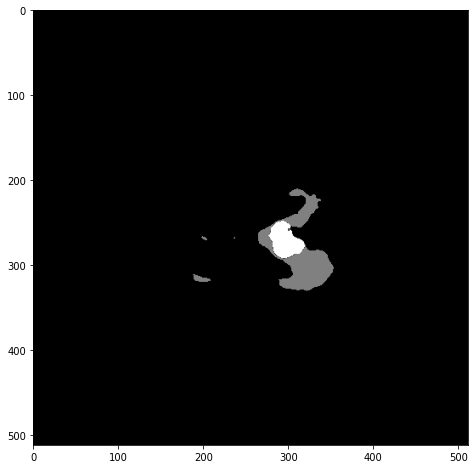

In [35]:
mask = nib.load(
    '/home/srivathsa/projects/studies/gad/dose_sim_seg/pred_sgad/Patient_0516_T1Gd/Patient_0516_T1Gd_seg.nii.gz'
).get_fdata()
print(mask.min(), mask.max())
print(mask.shape)
plt.imshow(mask[..., 108])